# Black-Scholes option pricing with Monte Carlo Notebook

The purpose of this notebook is to explore different methods for the valuation of options within the framework of the Black-Scholes pricing model with the use of Python. In particular, we will rely on Monte Carlo methods for the pricing of european call options, and compare the results with those obtained through the exact Black-Scholes solution.

As a minimal introduction, the Black-Scholes model states that the asset prices as a function of time, $S(t)$, follows a geometric brownian motion:

$$dS = S\mu dt + S\sigma dz$$

Let then have an option $f$, which will be a function of $S$ and $t$. Then, the process followed by this option will be described by:

$$df = \Bigl(\frac{\partial f}{\partial S}\mu S + \frac{\partial f}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 f}{\partial S^2}\Bigl)dt + \frac{\partial f}{\partial S}\sigma S dz$$

Let us consider the following portfolio $\prod$, composed of the option $f$ and a certain amount $\Delta$ of the underlying $S$:

$$\Pi=-f+\Delta S$$

If we differentiate, we have the following process:

$$d\Pi = -df + \frac{\partial f}{\partial S}dS = \Bigl(-\frac{\partial f}{\partial t}-\frac{1}{2}\sigma^2 S^2\frac{\partial^2 f}{\partial S^2} \Bigl)dt$$

We have set:

$$\Delta=\frac{\partial f}{\partial S}$$

Combining above, we obtained the Black-Scholes equation:

$$\frac{\partial f}{\partial t}+rS\frac{\partial f}{\partial S}+\frac{1}{2}\sigma^2 S^2\frac{\partial^2 f}{\partial S^2}=r f$$

The solution of the Black-Scholes equation for an european call option $C(S, t)$, given the maturity $T$ and strike price $X$ is given by:

$$C(S, t) = SN(d_1)-Xe^{-r(T-t)}N(d_2)$$

where we have:

$$d_1 = \frac{\ln(S/X)+\Bigl(r+\frac{\sigma^2}{2}\Bigl)(T-t)}{\sigma\sqrt{T-t}}$$

$$d_2 = \frac{\ln(S/X)+\Bigl(r-\frac{\sigma^2}{2}\Bigl)(T-t)}{\sigma\sqrt{T-t}}$$

and $N(d)$ is the cumulative normal distribution:

$$N(d) = \frac{1}{\sqrt{2\pi}}\int^{∞}_{-d}dx \exp(-x^2/2)$$

Importing packages

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
plt.style.use('fivethirtyeight')
import numpy.random as npr

# Analytical Solution

We define the solution based on the above discussion

In [12]:
def BS_Call_Exact(S,X,r,sigma,T,t):

    d1 = (np.log(S/X)+(r+((sigma**2)/2))*(T-t))/(sigma*np.sqrt((T-t)))
    d2 = d1-sigma*np.sqrt((T-t))

    ST = S*stats.norm.cdf(d1) - X*np.exp(-r*(T-t))*stats.norm.cdf(d2)

    return ST

We plot some solutions $C$ as function of t. We choose $S=100$ and use $X=95, 98, 100, 105$. In the remaining of this notebook, we will always set $T=1$, $r=0.06$, $\sigma=0.3$.

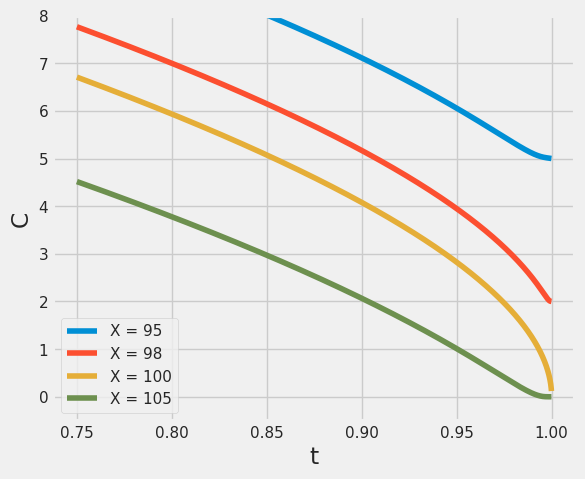

In [12]:
t = np.arange(0.75, 1.0, 0.0001)

plt.figure(figsize = (6,5))
plt.plot(t,BS_Call_Exact(100,95,0.06,0.3,1,t), label = 'X = 95')
plt.plot(t,BS_Call_Exact(100,98,0.06,0.3,1,t), label = 'X = 98')
plt.plot(t,BS_Call_Exact(100,100,0.06,0.3,1,t), label='X = 100')
plt.plot(t,BS_Call_Exact(100,105,0.06,0.3,1,t), label = 'X = 105')

plt.xlabel('t')
plt.ylabel('C')
plt.ylim(-0.5, 8)

plt.legend()
plt.show()

In particular, for $T-t=0$, we have the standard funcion for the call option at maturity:

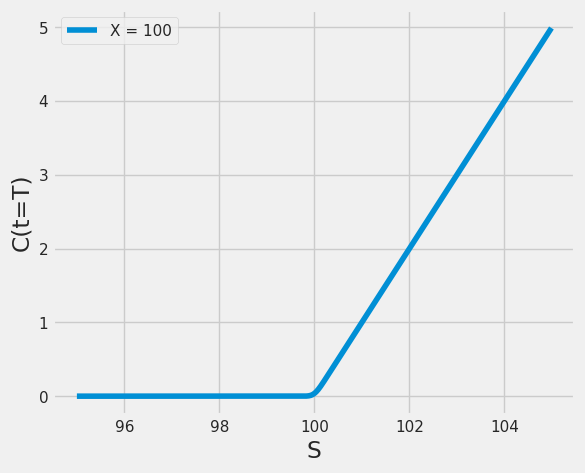

In [15]:
s = np.arange(95, 105, 0.01)

plt.figure(figsize = (6,5))
plt.plot(s,BS_Call_Exact(s,100,0.06,0.3,1,0.99999), label = 'X = 100')

plt.xlabel('S')
plt.ylabel('C(t=T)')

plt.legend()
plt.show()

# Numerical Solution via Monte Carlo Simulation

An alternate way to compute the call option price is to use Monte Carlo methods. The starting point is taking the Brownian motion equation for the underlying stock $S(t)$:

$$dS = S r dt + S\sigma dz$$

Compare with above, we have set $\mu=r$.  Here we are assuming we are using a risk-free setting.  We can discretise the differential equation via Euler scheme.  By doing so, we obtain the level of stock index $S_T$ at a future time $T$ given a level $S_t$ as:

$$S_T=S_e\exp\Bigl(\Bigl( r-\frac{1}{2}\sigma^2 \Bigl)(T-t) + \sigma\sqrt{T-t}z \Bigl),$$

where $z$ is a random variable.

We now simulate the process for $S_T$ using the Monte Carlo method. As an example, we set $r=0.06$, $\sigma=0.3$, $T-t=1$, $S_0=100$. We make $I=10^5$ iterations to ensure convergence and choose $M=100$ intervals for the time interval discretization.

In [4]:
r=0.06
sigma = 0.3
T = 1.0
S0 = 100

I = 100000
M = 100

dt = T/M

S = np.zeros((M+1, I))
S[0] = S0
for t in range(1,M+1):
    S[t] = S[t-1]*np.exp((r -0.5*sigma**2)*dt +sigma*np.sqrt(dt)*npr.standard_normal(I))


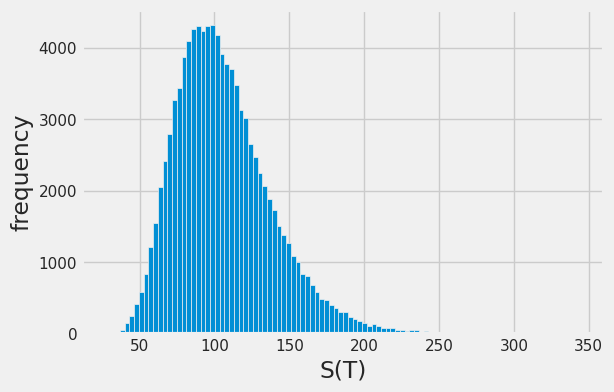

In [6]:
plt.figure(figsize=(6, 4))
plt.hist(S[-1], bins=100)
plt.xlabel('S(T)')
plt.ylabel('frequency')
plt.show()

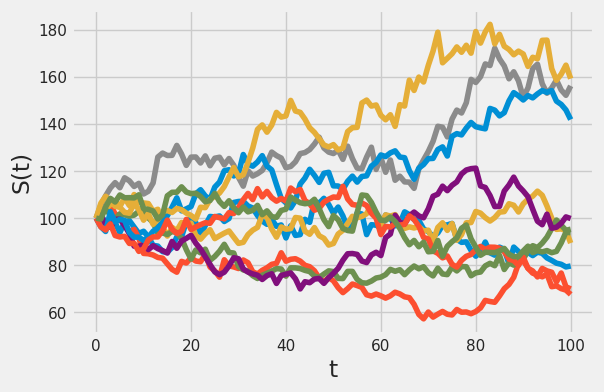

In [7]:

plt.figure(figsize=(6, 4))
plt.plot(S[:, :10])
plt.xlabel('t')
plt.ylabel('S(t)')
plt.show()

We know that, in the case of a call option, the payoff function at maturity is given by:

$$h(S_T)=\max(S_T-X, 0)$$

Then, in the case of risk-free setting, it can be shown that the call option price is given by:

$$C(T)=\exp(-r(T-t))\int^{∞}_{-∞}dS_T h(S_T) q(S_T)$$

where $q(S)$ is the probability density for the equivalent martingale process to $S_t$.  This integral can be discretised, giving:

$$C(T)=\exp(-r(T-t))\frac{1}{I}\sum^{I}_{i=1}h(S^{i}_T)$$

where the sum is taken over a collection of $S^{i}_{T}$ following a geometric brownian motion that can be generated via Monte-Carlo simulation.

In [10]:
def BS_Call_MC(S,X,r,sigma,T,t,I):

    data = np.zeros((I, 2))

    z = np.random.normal(0, 1, [1, I])

    #z = npr.standard_normal(I)

    ST = S*np.exp((T-t)*(r - 0.5*sigma**2)+sigma*np.sqrt(T-t)*z)

    data[:,1] = ST - X

    average = np.sum(np.amax(data, axis=1))/float(I)

    return np.exp(-r*(T-t))*average

Now we test our MC simulation with an example:

In [13]:
print('Monte Carlo:',BS_Call_MC(100,95,0.06,0.3,1,.999,100000))
print('Exact: ',BS_Call_Exact(100,95,0.06,0.3,1,.999))

Monte Carlo: 5.0031425582428755
Exact:  5.005699833982007


The above example is fairly good. What about another one?

In [14]:
print('Monte Carlo:',BS_Call_MC(100,95,0.06,0.3,1,.75,100000))
print('Exact: ',BS_Call_Exact(100,95,0.06,0.3,1,.75))

Monte Carlo: 9.574750141864206
Exact:  9.548802012535894


We can plot how the value of the Monte Carlo call option converges to the exact value as the number of iterations increases.  We here test if our simulation results converge to the analytical results.

<ipython-input-19-8b9540f34e0e>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, extension], ignore_index=True)


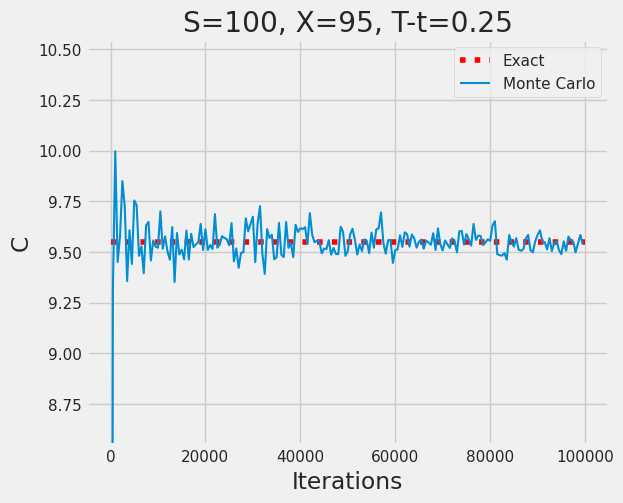

In [19]:
df = pd.DataFrame(columns=['Iter','BSc'])

for i in range(1, 100000, 500):
  extension = pd.DataFrame(
      {'Iter': [i], 'BSc': [BS_Call_MC(100,95,0.06,0.3,1,0.75,i)]}
      )
  df = pd.concat([df, extension], ignore_index=True)


plt.figure(figsize=(6,5))

plt.hlines(BS_Call_Exact(100,95,0.06,0.3,1,0.75),xmin=0,xmax= 100000,linestyle='dotted',colors='red',label = 'Exact')
plt.plot(df.set_index('Iter'),lw = 1.5, label = 'Monte Carlo')

plt.title('S=100, X=95, T-t=0.25')
plt.xlabel('Iterations')
plt.ylabel('C')
plt.ylim(BS_Call_Exact(100,95,0.06,0.3,1,0.75)-1,BS_Call_Exact(100,95,0.06,0.3,1,0.75)+1)
plt.legend()
plt.show()

<ipython-input-20-10b2d7247f6f>:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, extension], ignore_index=True)


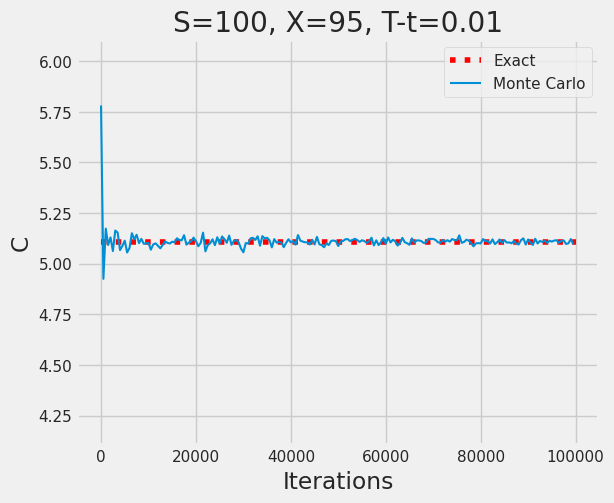

In [20]:
df = pd.DataFrame(columns=['Iter','BSc'])

for i in range(1, 100000, 500):
  extension = pd.DataFrame(
      {'Iter': [i], 'BSc': [BS_Call_MC(100,95,0.06,0.3,1,0.99,i)]}
      )
  df = pd.concat([df, extension], ignore_index=True)


plt.figure(figsize=(6,5))

plt.hlines(BS_Call_Exact(100,95,0.06,0.3,1,0.99),xmin=0,xmax= 100000,linestyle='dotted',colors='red',label = 'Exact')
plt.plot(df.set_index('Iter'),lw = 1.5, label = 'Monte Carlo')

plt.title('S=100, X=95, T-t=0.01')
plt.xlabel('Iterations')
plt.ylabel('C')
plt.ylim(BS_Call_Exact(100,95,0.06,0.3,1,0.99)-1,BS_Call_Exact(100,95,0.06,0.3,1,0.99)+1)
plt.legend()
plt.show()

Finally, we plot the Monte Carlo call option as a function of time and compare it with the exact result, for the values $S=100$ and $X=95, 98, 100, 105$.

<ipython-input-23-4f083d1226b2>:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, extension], ignore_index=True)


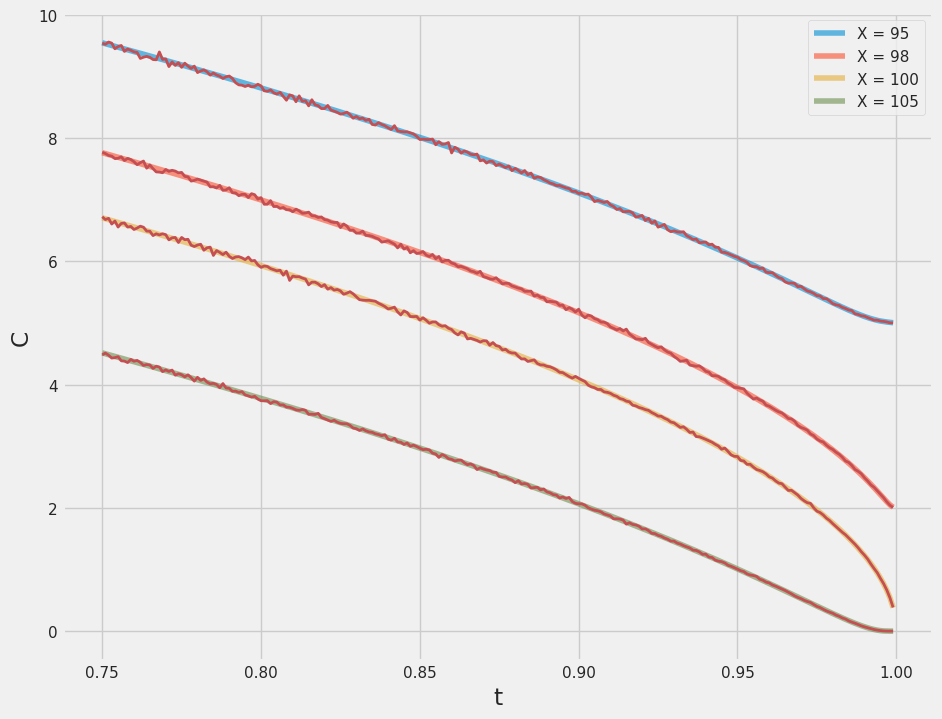

In [23]:
df = pd.DataFrame(columns=['t','95','98','100','105'])
t = np.arange(0.75, 1.0, 0.001)

for i in t:
  extension = pd.DataFrame(
      {'t': [i], '95': [BS_Call_MC(100,95,0.06,0.3,1,i,100000)],'98': [BS_Call_MC(100,98,0.06,0.3,1,i,100000)],
       '100': [BS_Call_MC(100,100,0.06,0.3,1,i,100000)],'105': [BS_Call_MC(100,105,0.06,0.3,1,i,100000)]}
      )
  df = pd.concat([df, extension], ignore_index=True)
  #df = df.append(, ignore_index=True)


plt.figure(figsize=(10,8))
plt.plot(t,BS_Call_Exact(100,95,0.06,0.3,1,t),alpha=0.6, label = 'X = 95')
plt.plot(t,BS_Call_Exact(100,98,0.06,0.3,1,t),alpha=0.6, label = 'X = 98')
plt.plot(t,BS_Call_Exact(100,100,0.06,0.3,1,t),alpha=0.6, label = 'X = 100')
plt.plot(t,BS_Call_Exact(100,105,0.06,0.3,1,t),alpha=0.6, label = 'X = 105')

plt.plot(df['t'],df['95'],lw=2,c='r')
plt.plot(df['t'],df['98'],lw=2,c='r')
plt.plot(df['t'],df['100'],lw=2,c='r')
plt.plot(df['t'],df['105'],lw=2,c='r')

plt.legend()
plt.xlabel('t')
plt.ylabel('C')

plt.show()


From the above, we see the simulations give very accurate approximation to the exact results we discussed at the beginning